In [ ]:
!pip install datasets
!pip install --upgrade transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import load_dataset


In [ ]:
asnq_dataset = load_dataset("asnq", split="train[:1000]")
wikiqa_dataset = load_dataset("wiki_qa", split="train[:1000]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20377568 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/930062 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

In [ ]:
asnq_dataset = asnq_dataset.train_test_split(test_size=0.1)
wikiqa_dataset = wikiqa_dataset.train_test_split(test_size=0.1)

In [ ]:
# Display the structure of the datasets
print("ASNQ structure:", asnq_dataset)
print("wikiqa structure:", wikiqa_dataset)

ASNQ structure: DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 900
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 100
    })
})
wikiqa structure: DatasetDict({
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 900
    })
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 100
    })
})


In [ ]:
#Print sample example
print("\nASNQ examples:")
print(asnq_dataset['train'][:5])

print("\ntrec examples:")
print(wikiqa_dataset['train'][:5])


ASNQ examples:
{'question': ["who does the dogs voice in a dog's purpose", 'when were health warnings put on cigarette packets', 'when was sergeant pepper released in the us', 'what are the 5 main characteristics of a mineral', 'when was the first hospital built in england'], 'sentence': ['^ Jump up to : Lincoln , Ross A. ( 2015 - 09 - 18 ) .', 'On March 3 , 2016 , Department of Health ( DOH ) secretary Janette Garin started the implementation of Republic Act 10643 , requiring tobacco manufacturers to include graphic health warnings on newer cigarette packaging .', "He asserts that , by 1968 , the album appeared vacuous against the emotional backdrop of the political and social upheavals of American life , describing it as `` a triumph of effects '' , but `` a Day - Glo tombstone for its time '' .", 'p. 10 .', 'The National Health Service , the principal provider of health care in Britain , was founded in 1948 , and took control of nearly all the hospitals .'], 'label': [0, 0, 0, 0, 0

In [ ]:
train_dataset = asnq_dataset["train"]
eval_dataset = asnq_dataset["test"]

In [ ]:
#Take pre train model bert-base-uncased
model = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#EDA Task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

asnq_ch = asnq_dataset['train'].select(range(500))
asnq_ch_df = pd.DataFrame(asnq_ch)

In [ ]:
# Feature Distribution
print("\nFeature Distribution:")
print("Number of questions:", len(set(asnq_chunk_df['question'])))
print("Number of sentences:", len(set(asnq_chunk_df['sentence'])))
print("Number of labels:", len(set(asnq_chunk_df['label'])))


Feature Distribution:
Number of questions: 494
Number of sentences: 497
Number of labels: 2


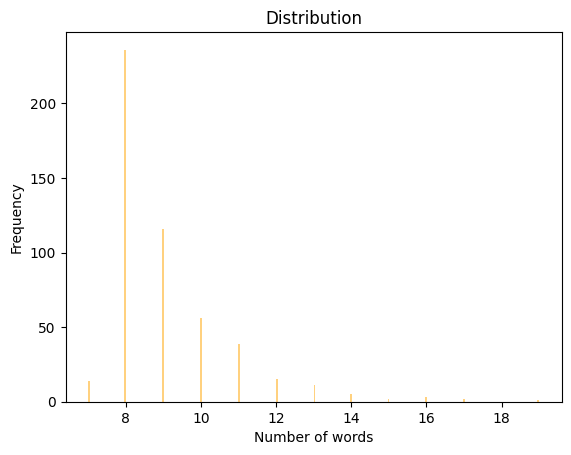

In [ ]:

import matplotlib.pyplot as plt
question_lengths = [len(q.split()) for q in asnq_chunk_df['question']]
plt.hist(question_lengths, bins=250, color='orange', alpha=0.5)
plt.title('Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
for split in wikiqa_dataset.keys():
    print(f"{split}:")
    print("Features:", wikiqa_dataset[split].features)
    print("Number of rows:", len(wikiqa_dataset[split]))

train:
Features: {'question_id': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'document_title': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1'], id=None)}
Number of rows: 900
test:
Features: {'question_id': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'document_title': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'label': ClassLabel(names=['0', '1'], id=None)}
Number of rows: 100


In [ ]:
print("\nSample entries from the dataset:")
for split in wikiqa_dataset.keys():
    print(f"{split}:")
    for i in range(3):
        example = wikiqa_dataset[split][i]
        print(f"Example {i+1}: {example}")
    print()


Sample entries from the dataset:
train:
Example 1: {'question_id': 'Q120', 'question': 'how were letters sealed in the 1800s', 'document_title': 'Seal (emblem)', 'answer': 'Thus, for example, the Great Seal of the United States , among other uses, appears on the reverse of the one-dollar bill ; and several of the seals of the U.S. states appear on their respective state flags .', 'label': 0}
Example 2: {'question_id': 'Q62', 'question': 'how did angelina jolie get her name?', 'document_title': 'Angelina Jolie', 'answer': 'Jolie achieved wide fame after her portrayal of video game heroine Lara Croft in Lara Croft: Tomb Raider (2001), and established herself among the highest-paid actresses in Hollywood with the sequel The Cradle of Life (2003).', 'label': 0}
Example 3: {'question_id': 'Q56', 'question': 'how are storm names determined?', 'document_title': 'Lists of tropical cyclone names', 'answer': 'The following are lists from which these tropical and subtropical cyclone names are de

In [ ]:
#take tokanizer and tokanoized datasets
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
import torch
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
import torch
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def find_answer_positions(tokenizer, context, answer):
    # Tokenize context and answer
    context_tokens = tokenizer.tokenize(context)
    answer_tokens = tokenizer.tokenize(answer)

    # Find start and end positions of answer tokens in context tokens
    for start_index in range(len(context_tokens)):
        if context_tokens[start_index:start_index + len(answer_tokens)] == answer_tokens:
            end_index = start_index + len(answer_tokens) - 1
            return start_index, end_index
    # Return None if answer not found in context
    return None, None

class ASNQDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512, subset_size=10000):
        self.dataset = dataset.select(range(subset_size))
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_row = self.dataset[idx]
        question = data_row['question']
        context = data_row['sentence']
        answer = data_row.get('answer', '')

        start_position, end_position = find_answer_positions(tokenizer, context, answer)
        if start_position is None or end_position is None:
            start_position = 0  # Default positions if answer not found
            end_position = 0

        encoding = self.tokenizer.encode_plus(question, context, max_length=self.max_length,
                                              padding='max_length', truncation=True, return_tensors="pt")
        encoding['start_positions'] = torch.tensor([start_position])
        encoding['end_positions'] = torch.tensor([end_position])

        return {key: val.squeeze() for key, val in encoding.items()}


asnq_train_dataset = ASNQDataset(asnq_dataset['train'], tokenizer, subset_size=900)
batch_size = 16  # Reduced batch size to further manage memory usage
asnq_data_loader = DataLoader(asnq_train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast
# Load the pre-trained DistilBERT model specialized for question-answering tasks
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
#train the model on asnq dataset
from torch.optim import AdamW
from torch.optim import SGD
from torch.utils.data import DataLoader
import torch

optimizer = AdamW(model.parameters(), lr=0.0001)
optimizer1 = SGD(model.parameters(), lr=1e-5)
epochs = 2

# Set the model to training mode
model.train()
#ASNQ
for epoch in range(num_epochs):
    total_loss = 0
    for batch in asnq_data_loader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Forward pass
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        start_positions=start_positions, end_positions=end_positions)
        # Backward pass and optimization
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {total_loss / len(asnq_data_loader)}')


Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors


Epoch 1/2 | Loss: 0.6009360539048845
Epoch 2/2 | Loss: 0.00857830006555703


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load WikiQA dataset from Hugging Face datasets library
dataset = load_dataset("wiki_qa")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define a function to preprocess examples
def preprocess(example):
    question = example["question"]
    context = example["answer"]
    label = example["label"]

    inputs = tokenizer(question, context, truncation=True, padding="max_length", max_length=512)

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "label": label
    }

# Preprocess the dataset
preprocessed_dataset = dataset.map(preprocess, batched=True)

# Split the dataset into training and validation sets
train_dataset = preprocessed_dataset["train"]
val_dataset = preprocessed_dataset["test"]
print(train_dataset[0])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6165 [00:00<?, ? examples/s]

Map:   0%|          | 0/2733 [00:00<?, ? examples/s]

Map:   0%|          | 0/20360 [00:00<?, ? examples/s]

{'question_id': 'Q1', 'question': 'how are glacier caves formed?', 'document_title': 'Glacier cave', 'answer': 'A partly submerged glacier cave on Perito Moreno Glacier .', 'label': 0, 'input_ids': [101, 2129, 2024, 10046, 10614, 2719, 1029, 102, 1037, 6576, 13563, 10046, 5430, 2006, 2566, 9956, 17921, 10046, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load WikiQA dataset from Hugging Face
dataset = load_dataset("wiki_qa")

# Load the pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

# Tokenize and preprocess the dataset
def tokenize_data(example):
    return tokenizer(example["question"], example["answer"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)

# Prepare DataLoader
train_inputs = torch.tensor(tokenized_dataset["train"]["input_ids"])
train_masks = torch.tensor(tokenized_dataset["train"]["attention_mask"])
train_labels = torch.tensor(tokenized_dataset["train"]["label"])

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

# Move model to device
model.to(device)

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer1 = SGD(model.parameters(), lr=1e-5)

# Number of training epochs
num_epochs = 3

# Set the model to training mode
model.train()

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Loss computation
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {total_loss / len(train_dataloader)}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2733 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 | Loss: 0.20567897216568762
Epoch 2/3 | Loss: 0.2050430450625059
Epoch 3/3 | Loss: 0.20500353623203538
